# Explore data overlap

In order to do tagging of the individual series within an MRI exam with the series type we need to explore the data overlap between the data in IDC and the data in reference study

- see discussion in the Data Collection section of [this paper](https://)
- and categorization of series into individual types in the in the data accompanying the mentioned paper (ISA-Tab metadata file a_assay_Davatzikos.txt column “Parameter value”).


### Environvent variables and imports

In [ ]:
myProjectID = '%%PUT-YOUR-PROJECT-ID-HERE%%'

In [ ]:
# Colab specific authentication helpers
from google.colab import auth

# Cloud storage (Google Drive and Google Cloud Stora) authentication helpers
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

# Other imports
from io import StringIO
import pandas as pd
try:
  import pydicom
except ModuleNotFoundError:
  !pip install pydicom
  import pydicom
import numpy as np
import random
from PIL import Image
from matplotlib import pyplot as plt

%matplotlib inline 

def get_idc_viewer_url(studyUID):
  return "https://viewer.imaging.datacommons.cancer.gov/viewer/"+studyUID

### Authentication procedure
In this cell we authorize the notebook to access our Google Drive and load the GCS python API service.

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Reference data exploration

Let's look at the source cvs. We access the csv from Google Drive and load it into a pandas dataframe.

In [ ]:
ISA_Tab_metadata = drive.CreateFile({'id': '1BMpypKAVubDAHihdiTAhy5VumOe7bHnw'})
metadata_string = StringIO(ISA_Tab_metadata.GetContentString())
metadata_df = pd.read_csv(metadata_string, sep=";")

In [ ]:
metadata_df.columns

Index(['Sample_Name', 'Protocol_REF', 'PV_instrument', 'PV_manufacturer',
       'PV_magnetic_field_strength', 'Unit', 'Term_Source_REF',
       'Term_Accession_Number', 'PV_MRI_assay', 'PV_repetition_time', 'Unit.1',
       'Term_Source_REF.1', 'Term_Accession_Number.1', 'PV_echo_time',
       'Unit.2', 'Term_Source_REF.2', 'Term_Accession_Number.2',
       'PV_pulse_sequence_type', 'PV_flip_angle_value', 'Unit.3',
       'Term_Source_REF.3', 'Term_Accession_Number.3', 'PV_inversion_time',
       'Unit.4', 'Term_Source_REF.4', 'Term_Accession_Number.4',
       'PV_number_of_slices', 'Assay_Name', 'Raw_Data_File',
       'Comment_Data_Repository', 'Comment_Data_Record_Accession',
       'Comment_Data_Record_URI', 'Protocol_REF.1', 'Protocol_REF.2',
       'Protocol_REF.3', 'Derived_Data_File', 'Comment_Data_Repository.1',
       'Comment_Data_Record_Accession.1', 'FV_diagnosis'],
      dtype='object')

### Extract the proposed series types

In [ ]:
print(i for i in metadata_df['PV_MRI_assay'].unique())

['T2-weighted image flair' 'T1-weighted post-contrast'
 'T1-weighted pre-contrast' 'T2-weighted image']


In [ ]:
metadata_df

,Sample_Name,Protocol_REF,PV_instrument,PV_manufacturer,PV_magnetic_field_strength,Unit,Term_Source_REF,Term_Accession_Number,PV_MRI_assay,PV_repetition_time,Unit.1,Term_Source_REF.1,Term_Accession_Number.1,PV_echo_time,Unit.2,Term_Source_REF.2,Term_Accession_Number.2,PV_pulse_sequence_type,PV_flip_angle_value,Unit.3,Term_Source_REF.3,Term_Accession_Number.3,PV_inversion_time,Unit.4,Term_Source_REF.4,Term_Accession_Number.4,PV_number_of_slices,Assay_Name,Raw_Data_File,Comment_Data_Repository,Comment_Data_Record_Accession,Comment_Data_Record_URI,Protocol_REF.1,Protocol_REF.2,Protocol_REF.3,Derived_Data_File,Comment_Data_Repository.1,Comment_Data_Record_Accession.1,FV_diagnosis
0,TCGA-02-0003,Magnetic Resonance Imaging,GENESIS_SIGNA,GE MEDICAL SYSTEMS,1.5,tesla,UO,UO:0000228,T2-weighted image flair,10002.000,millisecond,UO,UO:0000028,147.000,millisecond,UO,UO:0000028,IR,90.0,degree,UO,UO:0000185,2200.0,millisecond,UO,UO:0000028,25.0,TCGA-02-0003/1.3.6.1.4.1.14519.5.2.1.1706.4001...,doi:10.7937/K9/TCIA.2016.RNYFUYE9,Cancer Imaging Archive,doi:10.7937/K9/TCIA.2016.RNYFUYE9,http://doi.org/10.7937/K9/TCIA.2016.RNYFUYE9,Pre-processing,Segmentation labels of glioma sub-regions,Computer-aided Segmentation Approach,doi:10.7937/K9/TCIA.2017.KLXWJJ1Q,Cancer Imaging Archive,doi:10.7937/K9/TCIA.2017.KLXWJJ1Q,TCGA-GBM
1,TCGA-02-0003,Magnetic Resonance Imaging,GENESIS_SIGNA,GE MEDICAL SYSTEMS,1.5,tesla,UO,UO:0000228,T1-weighted post-contrast,650.000,millisecond,UO,UO:0000028,9.000,millisecond,UO,UO:0000028,SE,90.0,degree,UO,UO:0000185,NaN,NaN,NaN,NaN,25.0,TCGA-02-0003/1.3.6.1.4.1.14519.5.2.1.1706.4001...,doi:10.7937/K9/TCIA.2016.RNYFUYE9,Cancer Imaging Archive,doi:10.7937/K9/TCIA.2016.RNYFUYE9,http://doi.org/10.7937/K9/TCIA.2016.RNYFUYE9,Pre-processing,Segmentation labels of glioma sub-regions,Computer-aided Segmentation Approach,doi:10.7937/K9/TCIA.2017.KLXWJJ1Q,Cancer Imaging Archive,doi:10.7937/K9/TCIA.2017.KLXWJJ1Q,TCGA-GBM
2,TCGA-02-0003,Magnetic Resonance Imaging,GENESIS_SIGNA,GE MEDICAL SYSTEMS,1.5,tesla,UO,UO:0000228,T1-weighted pre-contrast,533.332,millisecond,UO,UO:0000028,8.000,millisecond,UO,UO:0000028,SE,90.0,degree,UO,UO:0000185,NaN,NaN,NaN,NaN,25.0,TCGA-02-0003/1.3.6.1.4.1.14519.5.2.1.1706.4001...,doi:10.7937/K9/TCIA.2016.RNYFUYE9,Cancer Imaging Archive,doi:10.7937/K9/TCIA.2016.RNYFUYE9,http://doi.org/10.7937/K9/TCIA.2016.RNYFUYE9,Pre-processing,Segmentation labels of glioma sub-regions,Computer-aided Segmentation Approach,doi:10.7937/K9/TCIA.2017.KLXWJJ1Q,Cancer Imaging Archive,doi:10.7937/K9/TCIA.2017.KLXWJJ1Q,TCGA-GBM
3,TCGA-02-0003,Magnetic Resonance Imaging,GENESIS_SIGNA,GE MEDICAL SYSTEMS,1.5,tesla,UO,UO:0000228,T2-weighted image,3500.000,millisecond,UO,UO:0000028,105.000,millisecond,UO,UO:0000028,SE,90.0,degree,UO,UO:0000185,NaN,NaN,NaN,NaN,25.0,TCGA-02-0003/1.3.6.1.4.1.14519.5.2.1.1706.4001...,doi:10.7937/K9/TCIA.2016.RNYFUYE9,Cancer Imaging Archive,doi:10.7937/K9/TCIA.2016.RNYFUYE9,http://doi.org/10.7937/K9/TCIA.2016.RNYFUYE9,Pre-processing,Segmentation labels of glioma sub-regions,Computer-aided Segmentation Approach,doi:10.7937/K9/TCIA.2017.KLXWJJ1Q,Cancer Imaging Archive,doi:10.7937/K9/TCIA.2017.KLXWJJ1Q,TCGA-GBM
4,TCGA-02-0006,Magnetic Resonance Imaging,GENESIS_SIGNA,GE MEDICAL SYSTEMS,1.5,tesla,UO,UO:0000228,T2-weighted image flair,10002.000,millisecond,UO,UO:0000028,147.000,millisecond,UO,UO:0000028,IR,90.0,degree,UO,UO:0000185,2200.0,millisecond,UO,UO:0000028,23.0,TCGA-02-0006/1.3.6.1.4.1.14519.5.2.1.1706.4001...,doi:10.7937/K9/TCIA.2016.RNYFUYE9,Cancer Imaging Archive,doi:10.7937/K9/TCIA.2016.RNYFUYE9,http://doi.org/10.7937/K9/TCIA.2016.RNYFUYE9,Pre-processing,Segmentation labels of glioma sub-regions,Computer-aided Segmentation Approach,doi:10.7937/K9/TCIA.2017.KLXWJJ1Q,Cancer Imaging Archive,doi:10.7937/K9/TCIA.2017.KLXWJJ1Q,TCGA-GBM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,TCGA-HT-A614,M

 The colum names of the above table have been changed comparing to the original values. For example spaces in the column names were changed to underscores for the dataframe to be importable into a BigQuery table.

 Importing this csv to a BigQuery table gives a more pleasant experience for working with large datasets form the Google Cloud Console, than developing queries from a colab notebook.

 

We match the data by series ID. We see the series ID as a substring of the `Assay_Name` column in the reference data and can use these values to `JOIN` the IDC data and ReferenceData together.

In [ ]:
%%bigquery --project=$myProjectID cohort_df

WITH
  reference_data AS (
  SELECT
    PV_MRI_assay,
    SPLIT(Assay_Name, '/')[OFFSET(1)] AS study_id,
    SPLIT(Assay_Name, '/')[OFFSET(2)] AS series_id,
  FROM
    `idc-external-007.ReferenceData.ReferenceDataTable`),
  idc_data AS (
  SELECT
    SeriesDescription,
    PatientID,
    collection_id,
    StudyInstanceUID,
    SeriesInstanceUID,
    gcs_url
  FROM
    `canceridc-data.idc_v2.dicom_all`)
SELECT
  PatientID,
  PV_MRI_assay,
  SeriesDescription,
  study_id,
  StudyInstanceUID,
  series_id,
  SeriesInstanceUID,
  gcs_url
FROM
  reference_data
INNER JOIN
  idc_data
ON
  idc_data.SeriesInstanceUID = reference_data.series_id
ORDER BY
  series_id

Check the matching results

In [ ]:
cohort_df.head(3)

,PatientID,PV_MRI_assay,SeriesDescription,study_id,StudyInstanceUID,series_id,SeriesInstanceUID,gcs_url
0,TCGA-76-6664,T2-weighted image,T2-WHOLE BRAIN,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,gs://idc-open/457fc15e-c54d-4938-b74f-d1073ff6...
1,TCGA-76-6664,T2-weighted image,T2-WHOLE BRAIN,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,gs://idc-open/bbeeb8da-c173-4a90-af77-e4d8d541...
2,TCGA-76-6664,T2-weighted image,T2-WHOLE BRAIN,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,gs://idc-open/8c594ac1-2c9a-4b4c-91ca-df37b896...


Check the data with an OVIF-Viewer

In [ ]:
print(get_idc_viewer_url(cohort_df['study_id'][100]))
print(cohort_df['gcs_url'][100])

https://viewer.imaging.datacommons.cancer.gov/viewer/1.3.6.1.4.1.14519.5.2.1.1188.4001.259303451742499057480927151400
gs://idc-open/0e945cde-088a-4485-a000-941078a0e653.dcm






---



---

In [ ]:
cohort_df

,PatientID,PV_MRI_assay,SeriesDescription,study_id,StudyInstanceUID,series_id,SeriesInstanceUID,gcs_url
0,TCGA-76-6664,T2-weighted image,T2-WHOLE BRAIN,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,gs://idc-open/457fc15e-c54d-4938-b74f-d1073ff6...
1,TCGA-76-6664,T2-weighted image,T2-WHOLE BRAIN,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,gs://idc-open/bbeeb8da-c173-4a90-af77-e4d8d541...
2,TCGA-76-6664,T2-weighted image,T2-WHOLE BRAIN,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,gs://idc-open/8c594ac1-2c9a-4b4c-91ca-df37b896...
3,TCGA-76-6664,T2-weighted image,T2-WHOLE BRAIN,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,gs://idc-open/584af468-4adb-44c9-bbbc-6f38c827...
4,TCGA-76-6664,T2-weighted image,T2-WHOLE BRAIN,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.280508857811...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,1.3.6.1.4.1.14519.5.2.1.1188.4001.101392134704...,gs://idc-open/07471b1f-7a19-49d4-a2fa-e998b45b...
...,...,...,...,...,...,...,...,...
55920,TCGA-12-1602,T2-weighted image,SAG TSE3D T2,1.3.6.1.4.1.14519.5.2.1.8862.4001.322746683938...,1.3.6.1.4.1.14519.5.2.1.8862.4001.322746683938...,1.3.6.1.4.1.14519.5.2.1.8862.4001.955499093208...,1.3.6.1.4.1.14519.5.2.1.8862.4001.955499093208...,gs://idc-open/a742bf70-e03a-4ca2-86f4-914748c6...
55921,TCGA-12-1602,T2-weighted image,SAG TSE3D T2,1.3.6.1.4.1.14519.5.2.1.8862.4001.322746683938...,1.3.6.1.4.1.14519.5.2.1.8862.4001.322746683938...,1.3.6.1.4.1.14519.5.2.1.8862.4001.955499093208...,1.3.6.1.4.1.14519.5.2.1.8862.4001.955499093208...,gs://idc-open/5f89fa04-f126-4649-bcbf-e2cf2066...
55922,TCGA-12-1602,T2-weighted image,SAG TSE3D T2,1.3.6.1.4.1.14519.5.2.1.8862.4001.322746683938...,1.3.6.1.4.1.14519.5.2.1.8862.4001.322746683938...,1.3.6.1.4.1.14519.5.2.1.8862.4001.955499093208...,1.3.6.1.4.1.14519.5.2.1.8862.4001.955499093208...,gs://idc-open/e140e4da-2f67-41f4-9ca1-da0dbd12...
55923,TCGA-12-1602,T2-weighted image,SAG TSE3D T2,1.3.6.1.4.1.14519.5.2.1.8862.4001.322746683938...,1.3.6.1.4.1.14519.5.2.1.8862.4001.322746683938...,1.3.6.1.4.1.14519.5.2.1.8862.4001.955499093208...,1.3.6.1.4.1.14519.5.2.1.8862.4001.955499093208...,gs://idc-open/969edaac-4e2e-4dc4-8828-1cf793ef...


Define a small helper function to download a number of sample images from the cohort.



In [ ]:
def sample_cohort(number_of_samples):
    sample_images = []
    for row in random.sample(range(len(cohort_df)), len(cohort_df))[:number_of_samples]:
        gcs_url = cohort_df['gcs_url'][row]
        study_id = cohort_df['StudyInstanceUID'][row]
        series_id = cohort_df['SeriesInstanceUID'][row]
        object_name = gcs_url.split('/')[-1]
        !gsutil -q -u $myProjectID cp $gcs_url /tmp/$study_id/$series_id/$object_name
        sample_images.append(f'/tmp/{study_id}/{series_id}/{object_name}')
    return sample_images

Examine a random image from the cohort


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name....: , 
Patient ID........: TCGA-02-0060
Modality..........: MR
Image Type........: ['ORIGINAL', 'PRIMARY', 'OTHER']
Series Description: T2 FLAIR2MM25FOV
Study Date........: 20000228
Image size........: 256 x 256
Pixel Spacing.....: [0.976562, 0.976562]
------------------------------------
Slice location....: 13.79999924
Intensities stdev.: 359.8783608102244


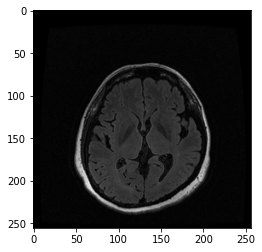

In [ ]:
# Load image with pydicom
ds = pydicom.dcmread(sample_cohort(1)[0])

# Normal mode:
print()
print(f"SOP Class........: {ds.SOPClassUID} ({ds.SOPClassUID.name})")
print()

pat_name = ds.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print(f"Patient's Name....: {display_name}")
print(f"Patient ID........: {ds.PatientID}")
print(f"Modality..........: {ds.Modality}")
print(f"Image Type........: {ds.ImageType}")
print(f"Series Description: {ds.SeriesDescription}")
print(f"Study Date........: {ds.StudyDate}")
print(f"Image size........: {ds.Rows} x {ds.Columns}")
print(f"Pixel Spacing.....: {ds.PixelSpacing}")
print(f"------------------------------------")

# use .get() if not sure the item exists, and want a default value if missing
print(f"Slice location....: {ds.get('SliceLocation', '(missing)')}")
print(f"Intensities stdev.: {np.std(ds.pixel_array)}")

# plot the image using matplotlib
plt.imshow(ds.pixel_array, cmap=plt.cm.gray)

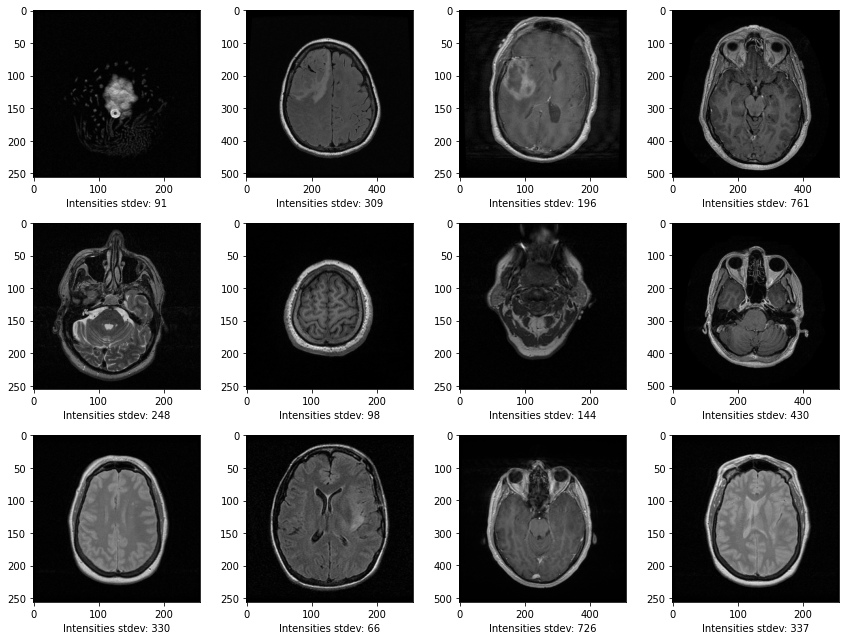

In [ ]:
plt.subplots(3, 4, figsize=(12, 9))
sample_image_files = sample_cohort(12)
for i in range(len(sample_image_files)):
    ds = pydicom.dcmread(sample_image_files[i])
    plt.subplot(3, 4, i + 1)
    plt.xlabel(f"Intensities stdev: {int(np.std(ds.pixel_array))}")
    plt.imshow(ds.pixel_array, cmap="gray")
plt.tight_layout()
plt.show()

---